In [1]:
%load_ext autoreload
%autoreload 2

import jax  # noqa: I001
jax.config.update("jax_enable_x64", True)

import numpyro  # noqa: E402, I001
numpyro.set_host_device_count(4)

import numpy as np  # noqa: E402, I001

import ultraplot as uplt  # noqa: E402, I001

## v4 Model Explainer

The `v4` models are based on the idea that 

- a source at a given redshift responds to sources at other redshifts with some value $R_o$
  which is approximately universal when described relative to the given source so that 
  $R_o(z, z_s) = R_o(z - z_s)$
- the sources at the other redshifts follow something like the true $n_t(z)$ for the 
  entire survey, possibly with weighting for flux and/or size
- the final effective n(z) for lensing for a given tomographic bin is a combination of the
  cross-redshift response and a redshift dependent same-redshift calibration $m(z)$ which we
  write as $R_m(z)$

Putting these ideas together and denoting the redshift distribution of the sources in a given tomographic bin
as $n_i(z)$, we get for the same-redshift shear calibration term


$$
n^{(m)}_{eff,i}(z) = [1 + m(z)] n_i(z)
$$

The cross-redshift term is nearly a convolution of effects as described above

$$
n^{(o)}_{eff,i}(z) = \int dz_s R_o(z - z_s) n_t(z) n_i(z_s)
$$

The three terms above are the cross-redshift response for a source at redshift $z_s$ blending with 
another object along the line-of-site at redshift $z$, the density of other objects at redshift $z$, 
and the density of sources at redshift $z_s$. This term is nearly a convolution, but not quite.

The total effective redshift distribution for lensing is the sum of these two terms

$$
n_{eff,i}(z) = [1 + m(z)] n_i(z) + \int dz_s R_o(z - z_s) n_t(z) n_i(z_s)
$$

## A Specific Model

In order to make progress on a model, we assume that $R_o(z - z_s)$ has one value below the source $z_s$, is zero at the source $z_s$, and has another value above the source $z_s$. Forcing $R_o$ to be zero at the source redhsift ensures that this term does not capture any same-redshift calibration issues. Below we use smoothed "bumps" made of sigmoid functions and use the COSMSO riz flux template for the true redshift distribution.

First, let's plot up a model for $R_o$ for some representative values of the low-z response being 0.1 and the high-z response being 0.01.


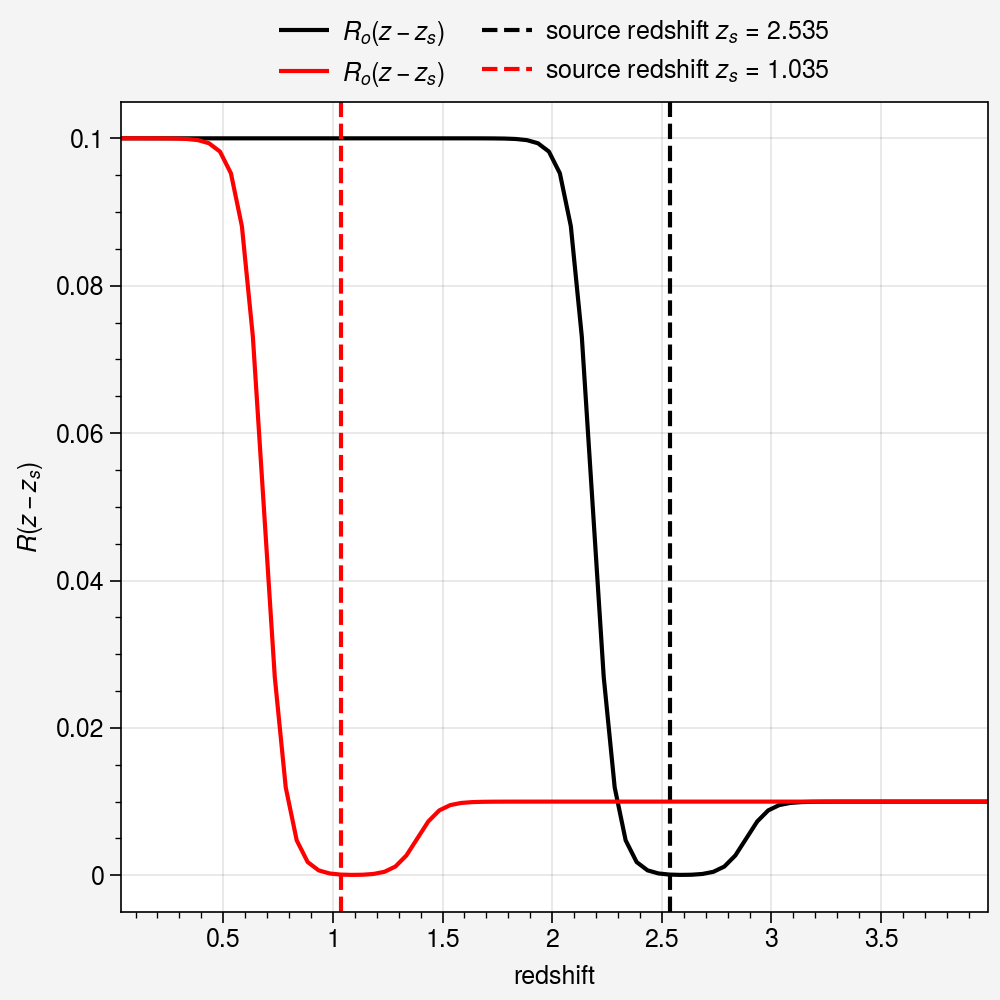

In [6]:
from des_y6_imsim_analysis.utils import GMODEL_COSMOS_NZ, GMODEL_COSMOS_Z

z = GMODEL_COSMOS_Z[1:-1]
nz = GMODEL_COSMOS_NZ
assert z.shape == nz.shape


def _sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def _bump(z, a, b, w):
    # always use jax.nn.sigmoid here to ensure stable autodiff
    return _sigmoid((z - a) / w) * (1 - _sigmoid((z - b) / w))


def _kern(z, zc, ml, mh):
    _s = 0.05
    return ml * _bump(z, -1, zc - 7 * _s, _s) + mh * _bump(z, zc + 7 * _s, 6, _s)


_, axs = uplt.subplots(figsize=(5, 5))

axs.plot(z, _kern(z, z[50], 0.1, 0.01), label="$R_o(z - z_s)$", color="k")
axs.axvline(z[50], label=f"source redshift $z_s$ = {z[50]:1.3f}", linestyle="dashed", color="k")
axs.plot(z, _kern(z, z[20], 0.1, 0.01), label="$R_o(z - z_s)$", color="r")
axs.axvline(z[20], label=f"source redshift $z_s$ = {z[20]:1.3f}", linestyle="dashed", color="r")
axs.format(
    xlabel="redshift",
    ylabel="$R(z-z_s)$"
)
axs.legend(loc="t", frameon=False, ncols=2)

We have made some arbitrary choices for how smooth to make the transitions between the different regions of the model and have plotted two example redshifts at roughly 1 and 2.5.

Now we can perform the integral above to produce an estimate of the cross-redshift term in the effective redshift distribution.

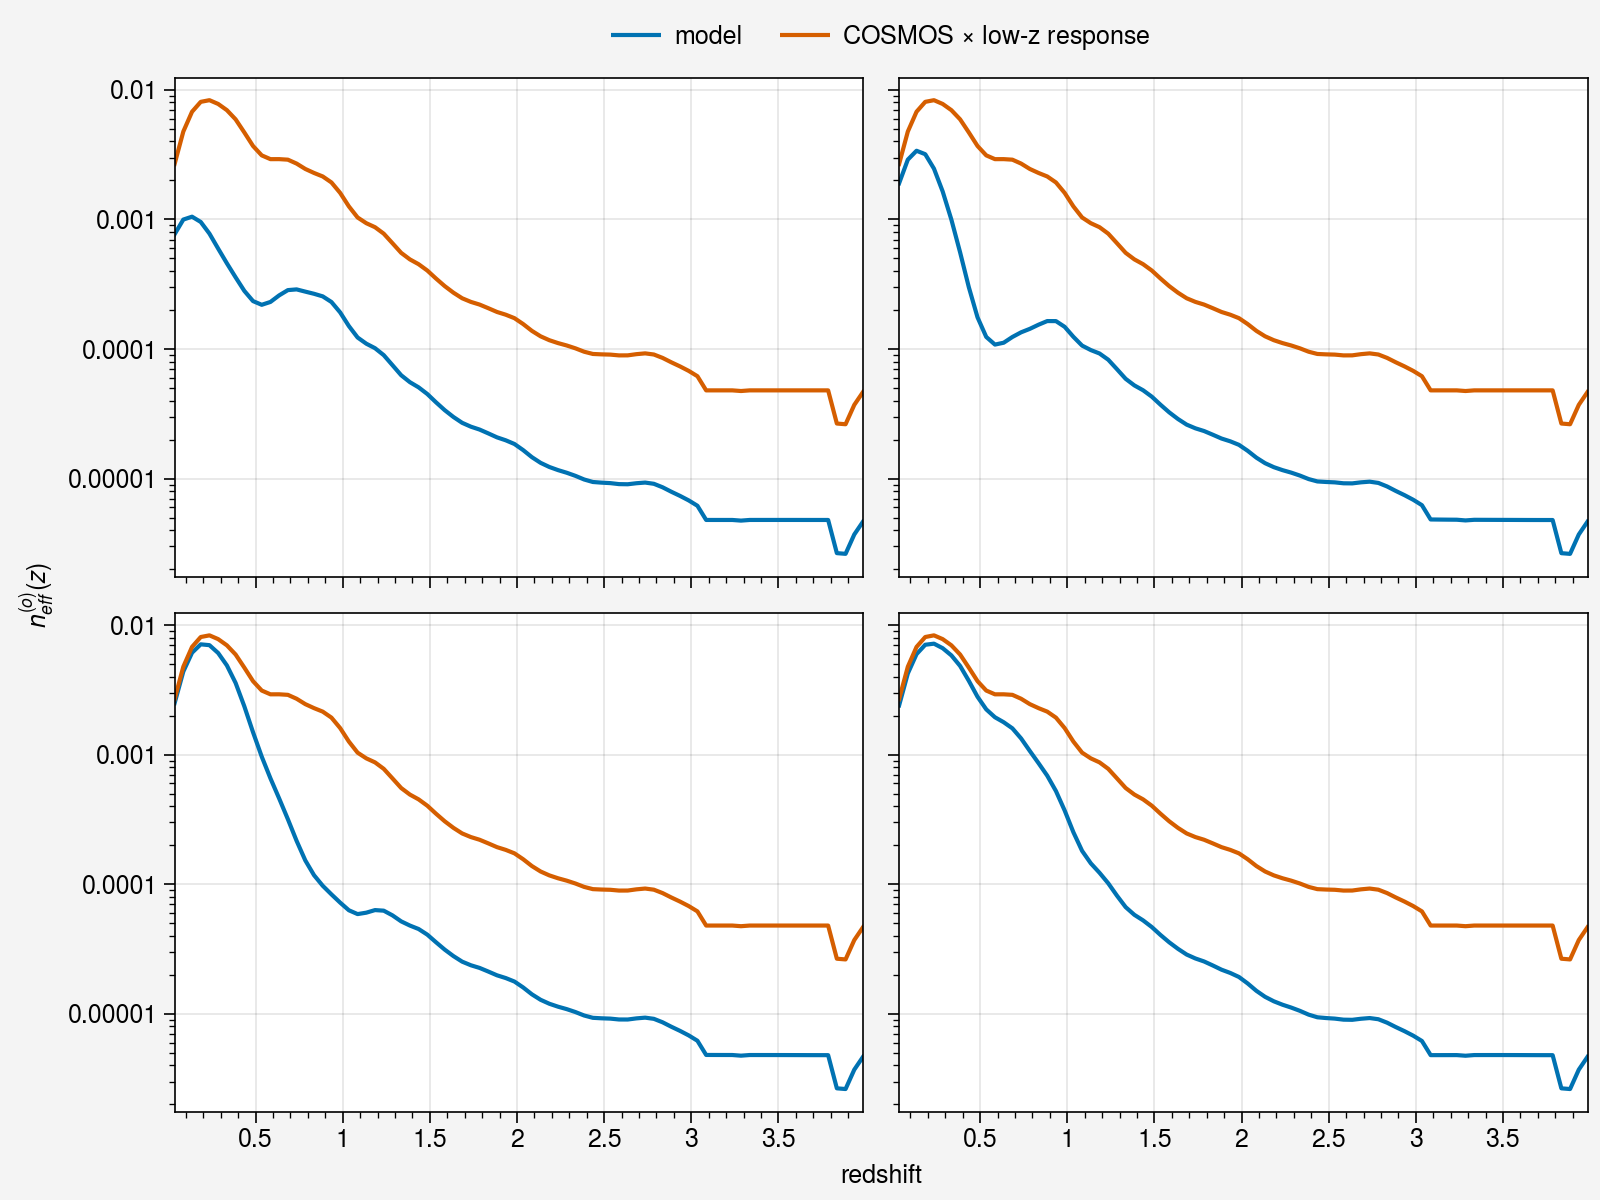

In [17]:
from des_y6_imsim_analysis.utils import read_data

data = read_data("../../data/N_gamma_alpha_v3_statistical.hdf5")


fig, axs = uplt.subplots(figsize=(8, 6), nrows=2, ncols=2)

r = 0.1
s = 0.01

tind = 0
for ix in range(2):
    for jx in range(2):
        ax = axs[ix, jx]

        # do this two different ways since one is more JAX-friendly
        # and we will want that
        tkern = np.zeros((nz.shape[0], nz.shape[0]))
        for i in range(nz.shape[0]):
            tkern[i] = _kern(
                z,
                z[i],
                r,
                s,
            ) * nz * data.nzs[tind, i]

        tot = np.sum(tkern, axis=0)

        btot = np.sum(
            _kern(
                z.reshape((1, -1)),
                z.reshape((-1, 1)),
                r,
                s,
            ) * nz.reshape((1, -1)) * data.nzs[tind].reshape((-1, 1)),
            axis=0,
        )

        assert np.allclose(btot, tot)

        ax.plot(z, tot, linestyle="solid", label="model" if tind == 0 else None)
        ax.plot(z, r * nz, label=r"COSMOS $\times$ low-z response" if tind == 0 else None)
        ax.set_yscale("symlog", linthresh=1e-7)
        ax.format(
            xlabel="redshift",
            ylabel=r"$n^{(o)}_{eff}(z)$"
        )
        tind += 1

fig.legend(loc="t", frameon=False)

We can see that for this model, the additive cross-redshift blending response term can deviate from the COSMOS template scaled by some value.

Here is the same plot but setting the low-z and high-z response to be the same

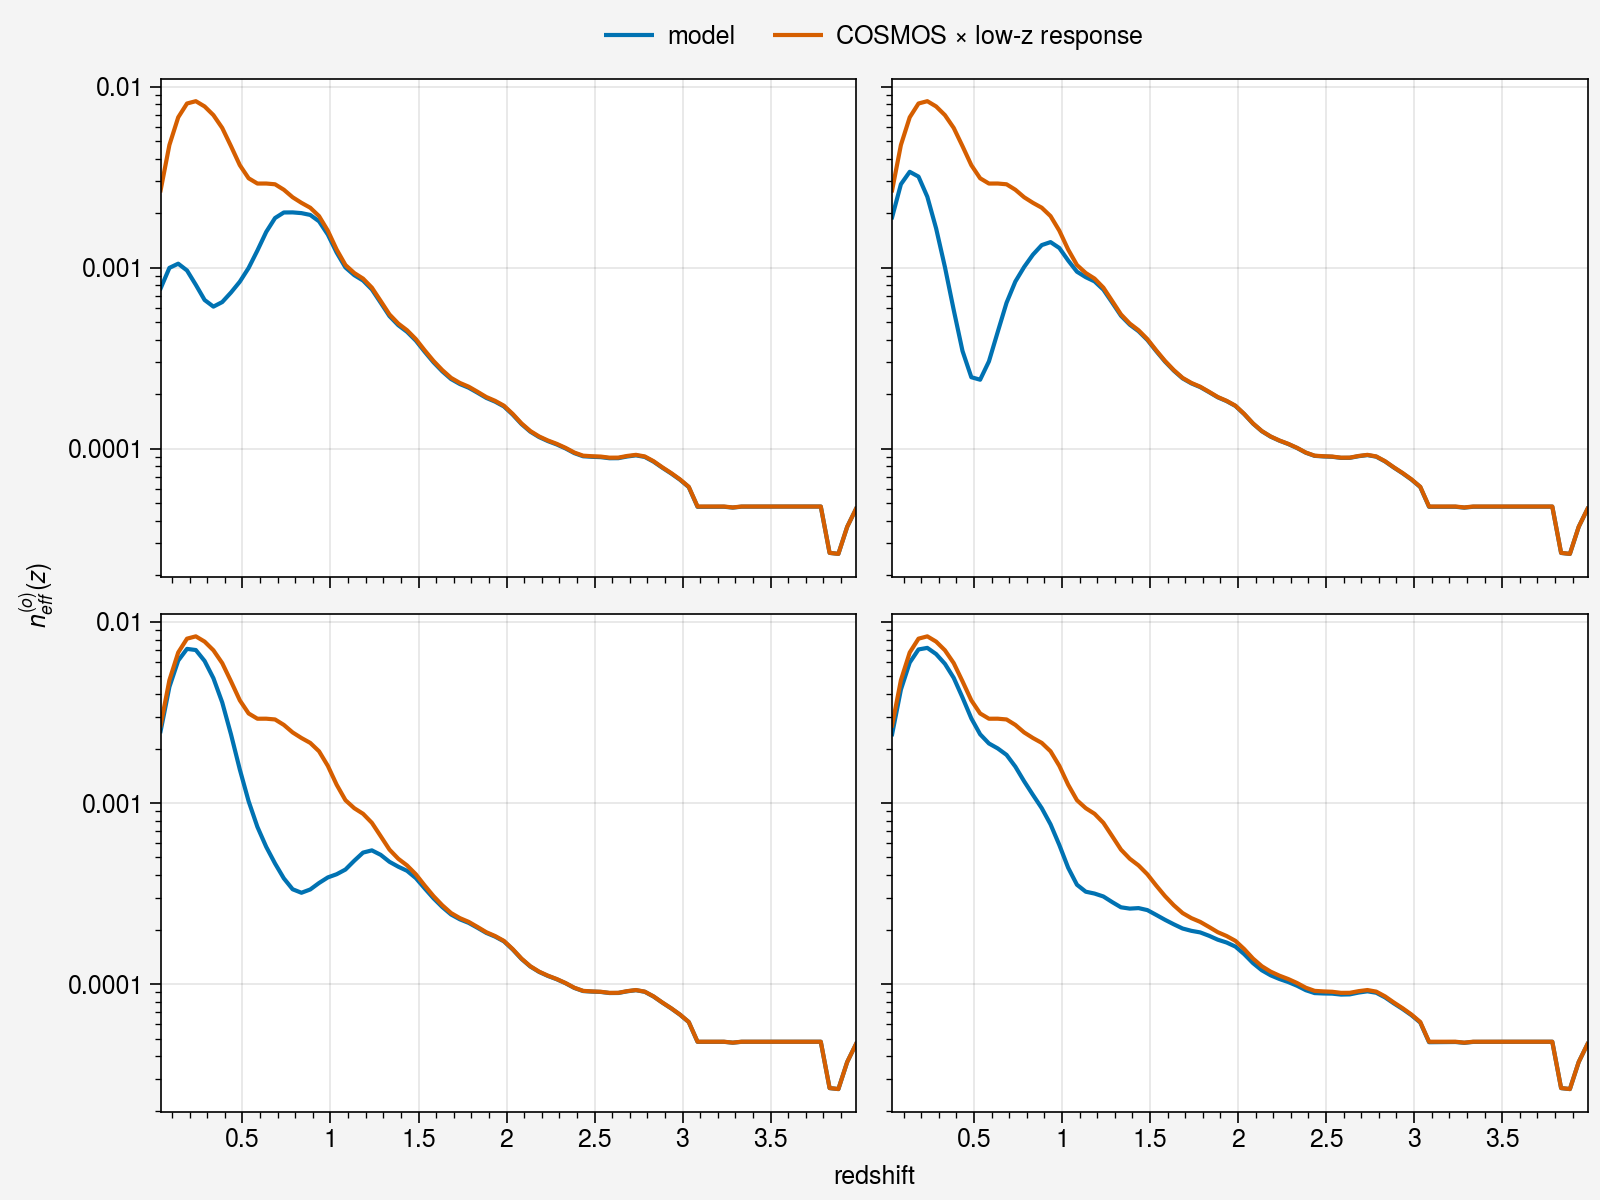

In [18]:
fig, axs = uplt.subplots(figsize=(8, 6), nrows=2, ncols=2)

r = 0.1
s = 0.1

tind = 0
for ix in range(2):
    for jx in range(2):
        ax = axs[ix, jx]

        # do this two different ways since one is more JAX-friendly
        # and we will want that
        tkern = np.zeros((nz.shape[0], nz.shape[0]))
        for i in range(nz.shape[0]):
            tkern[i] = _kern(
                z,
                z[i],
                r,
                s,
            ) * nz * data.nzs[tind, i]

        tot = np.sum(tkern, axis=0)

        btot = np.sum(
            _kern(
                z.reshape((1, -1)),
                z.reshape((-1, 1)),
                r,
                s,
            ) * nz.reshape((1, -1)) * data.nzs[tind].reshape((-1, 1)),
            axis=0,
        )

        assert np.allclose(btot, tot)

        ax.plot(z, tot, linestyle="solid", label="model" if tind == 0 else None)
        ax.plot(z, r * nz, label=r"COSMOS $\times$ low-z response" if tind == 0 else None)
        ax.set_yscale("symlog", linthresh=1e-7)
        ax.format(
            xlabel="redshift",
            ylabel=r"$n^{(o)}_{eff}(z)$"
        )
        tind += 1

fig.legend(loc="t", frameon=False)

Here we see even more interesting behavior due to the shapes of the tomographic bin redshift distributions.